# Data Retrieval

In [2]:
import pandas as pd
import csv
import re
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor

In [3]:
# File path for cities: San Francisco(sf), Okaland(ok), and Santa Clara(sc)

file_url = '/Users/xzhou/github/project_archives/files_airbnb/{}/calendar.csv'

sf_file = file_url.format('sf_airbnb')
ok_file = file_url.format('ok_airbnb')
sc_file = file_url.format('sc_airbnb')

In [4]:
# Loaded price by date information for each city

pricing_sf = pd.read_csv(sf_file, parse_dates=['date'])
pricing_ok = pd.read_csv(ok_file, parse_dates=['date'])
pricing_sc = pd.read_csv(sc_file, parse_dates=['date'])

print(pricing_sf.shape, pricing_ok.shape, pricing_sc.shape)

(2420680, 4) (1057770, 4) (2068820, 4)


In [5]:
# Concatenated all files into one
# Created keys for each file for future references

frames = [pricing_sf, pricing_ok, pricing_sc]
keys = ['pricing_sf', 'pricing_ok', 'pricing_sc']

df_pricing = pd.concat(frames, keys=keys)

df_pricing.head(10)

listing_id       date available price
pricing_sf 0         958 2019-08-05         f   NaN
           1         958 2019-08-04         f   NaN
           2         958 2019-08-03         f   NaN
           3         958 2019-08-02         f   NaN
           4         958 2019-08-01         f   NaN
           5         958 2019-07-31         f   NaN
           6         958 2019-07-30         f   NaN
           7         958 2019-07-29         f   NaN
           8         958 2019-07-28         f   NaN
           9         958 2019-07-27         f   NaN

# Data Exploration

## Smaller Set of Data

In [6]:
# Filter to houses that are available and have listing prices

df_pricing_smaller = df_pricing[df_pricing['available']=='t']
df_pricing_smaller = df_pricing_smaller.copy()

print('Dimension for df_pricing_smaller: ', df_pricing_smaller.shape)
print ('\nNumber of Unique ids: ', df_pricing_smaller.listing_id.nunique())

Dimension for df_pricing_smaller:  (2588352, 4)

Number of Unique ids:  13452


In [7]:
df_pricing_smaller.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

## Data Format

In [8]:
def apply2df(df, column_names, function):
    """
    This enables various functions to be applied to multiple columns of dataframe.
    Input: dataframe, columns to apply function to (list), function
    Return: updated dataframe
    """
    for column in column_names:
        df[column] = df[column].apply(lambda x: function(x))
    return df

### Currency

In [9]:
# Noted currencies are formated as strings and need to be converted to float

def currency2float(string):
    """
    Convert currency to float
    """
    float_ = float(str(string).strip('$').replace(',',''))
    return float_

In [10]:
# Converted price to float format

curriencies = ['price']

df_pricing_smaller = apply2df(df_pricing_smaller, curriencies, currency2float)

## Outliers

In [11]:
percentiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]

df_pricing_smaller.price.describe(percentiles=percentiles)

count    2.588352e+06
mean     2.056189e+02
std      7.335415e+02
min      1.000000e+01
5%       4.000000e+01
10%      5.000000e+01
25%      7.800000e+01
50%      1.290000e+02
75%      2.090000e+02
90%      3.500000e+02
95%      5.000000e+02
max      1.024520e+05
Name: price, dtype: float64

In [12]:
# Removed outliers based on 'price'. Use 5% and 95% percentiles as cutoff

five_percentile = np.percentile(df_pricing_smaller.price, 5)
ninety_five_percentile = np.percentile(df_pricing_smaller.price, 95)

df_pricing_smaller = df_pricing_smaller[(
                        df_pricing_smaller.price>=five_percentile)
                        & (df_pricing_smaller.price<=ninety_five_percentile)]

In [13]:
print ('df_pricing_smaller dimensions: ', df_pricing_smaller.shape)

df_pricing_smaller dimensions:  (2346265, 4)


## Null Values

In [14]:
df_pricing_smaller.isnull().sum()

listing_id    0
date          0
available     0
price         0
dtype: int64

In [15]:
df_pricing_smaller.shape

(2346265, 4)

In [16]:
columns2display = ['date', 'price']

df_pricing_smaller[columns2display].describe(include='all')

,date,price
count,2346265,2.346265e+06
unique,375,NaN
top,2018-11-03 00:00:00,NaN
freq,8671,NaN
first,2018-08-06 00:00:00,NaN
last,2019-08-15 00:00:00,NaN
mean,NaN,1.537473e+02
std,NaN,9.694863e+01
min,NaN,4.000000e+01
25%,NaN,8.000000e+01


## Seasonality Data

### Added Month and Day-of-Week(DOW) Features

In [17]:
# Added 'month' column to extract month of date
# Added 'day_of_week' column to extact day of week. 
# Default format: Monday=0, Sunday=6

df_pricing_smaller['month'] = df_pricing_smaller['date'].dt.month
df_pricing_smaller['day_of_week'] = df_pricing_smaller['date'].dt.weekday


print('df_pricing_smaller dimensions', df_pricing_smaller.shape)
display(df_pricing_smaller.head())

df_pricing_smaller dimensions (2346265, 6)


listing_id       date available  price  month  day_of_week
pricing_sf 63         958 2019-05-02         t  181.0      5            3
           64         958 2019-05-01         t  181.0      5            2
           65         958 2019-04-30         t  181.0      4            1
           66         958 2019-04-29         t  181.0      4            0
           67         958 2019-04-28         t  181.0      4            6

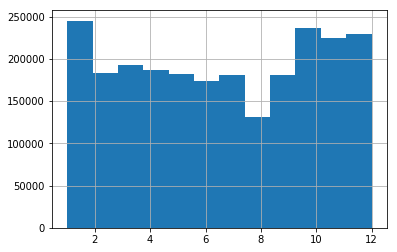

In [18]:
# Checked the price distribution by month

df_pricing_smaller.month.hist(bins=12)

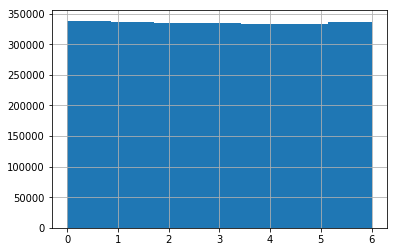

In [19]:
# Checked the price distribution by day of week

df_pricing_smaller.day_of_week.hist(bins=7)

### Pricing By Month by DOW

In [20]:
# Group by month by day of week, and calculate an average pricing

df_pricing_by_mon_dow = df_pricing_smaller  \
                            .groupby(['listing_id', 'month', 'day_of_week'])  \
                            .price.mean()  \
                            .reset_index()
df_pricing_by_mon_dow.head(100)

,listing_id,month,day_of_week,price
0,958,1,0,180.0
1,958,1,1,179.5
2,958,1,2,179.5
3,958,1,3,179.0
4,958,1,4,183.0
5,958,1,5,185.0
6,958,1,6,180.0
7,958,2,0,179.0
8,958,2,1,179.0
9,958,2,2,179.0


In [21]:
# Check for null values if any

df_pricing_by_mon_dow.isnull().sum()

listing_id     0
month          0
day_of_week    0
price          0
dtype: int64

In [22]:
# Rename the average price column to avoid confusion

df_pricing_by_mon_dow.rename(columns={'price':'price_by_mon_dow'}, inplace=True)

In [23]:
df_pricing_by_mon_dow.shape

(625086, 4)

In [24]:
df_pricing_by_mon_dow.head()

,listing_id,month,day_of_week,price_by_mon_dow
0,958,1,0,180.0
1,958,1,1,179.5
2,958,1,2,179.5
3,958,1,3,179.0
4,958,1,4,183.0


In [25]:
columns2display = ['price_by_mon_dow']

df_pricing_by_mon_dow[columns2display].describe()

,price_by_mon_dow
count,625086.000000
mean,154.025145
std,97.041053
min,40.000000
25%,80.000000
50%,128.000000
75%,199.000000
max,500.000000


### Convert Month, DOW Info to Dummy Variables

In [26]:
def get_month(number):
    """
    Given a number, return the name of month.
    
    """
    month_lookup = {1:'Jan.', 2:'Feb.', 3:'Mar.', 4:'Apr.', 5:'May.', 6:'Jun.',
                    7:'Jul.', 8:'Aug.', 9:'Sep.', 10:'Oct.', 11:'Nov.', 12:'Dec.'}
    
    return month_lookup[number]

In [27]:
def get_dow(number):
    """
    Given a number, return the day of week (dow)
    
    """
    weekday_lookup = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
                      4:'Friday', 5:'Saturday', 6:'Sunday'}
    
    return weekday_lookup[number]

In [28]:
# Added names for month, and day of week(dow) informaiton

df_pricing_by_mon_dow = apply2df(df_pricing_by_mon_dow, ['month'], get_month )
df_pricing_by_mon_dow = apply2df(df_pricing_by_mon_dow, ['day_of_week'], get_dow )

In [29]:
# Converted month, and dow information to dummy variables

df_pricing_final = pd.get_dummies(df_pricing_by_mon_dow, 
                                  prefix='',
                                  prefix_sep='',
                                  columns=['month', 'day_of_week'])

print ('df_pricing_final dimensions: ', df_pricing_final.shape)
df_pricing_final.head()

df_pricing_final dimensions:  (625086, 21)


,listing_id,price_by_mon_dow,Apr.,Aug.,Dec.,Feb.,Jan.,Jul.,Jun.,Mar.,...,Nov.,Oct.,Sep.,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,958,180.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,958,179.5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,958,179.5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,958,179.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,958,183.0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [30]:
df_pricing_final.columns

Index(['listing_id', 'price_by_mon_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.', 'May.', 'Nov.', 'Oct.', 'Sep.',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

## test

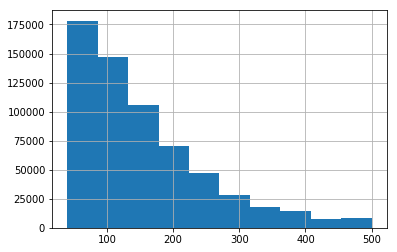

In [31]:
df_pricing_final.price_by_mon_dow.hist()

In [32]:
df_pricing_final['price_by_mon_dow'] = df_pricing_final['price_by_mon_dow'].apply(lambda x: np.log(x))

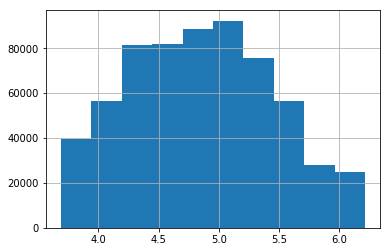

In [33]:
df_pricing_final.price_by_mon_dow.hist()

## Combined Seasonality Data with Previously Identified Features

In [34]:
# Loaded listings with identified important features

pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'
listings = pkl_file.format('df_listings_selected_features')

df_listings_features = pd.read_pickle(listings)

print ('df_listings_features dimensions: ', df_listings_features.shape)
df_listings_features.head()

df_listings_features dimensions:  (9062, 314)


,id,host_yrs,host_response_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,...,amenities_Shampoo,amenities_Single level home,amenities_Smoke detector,amenities_Stepfree access,amenities_TV,amenities_Wifi,amenities_translation missing enhosting_amenity_49,amenities_translation missing enhosting_amenity_50,ref_district,ref_jurisdiction
0,958,12,0.92,1,3,1.0,1.0,2.0,5.135798,1,...,1,0,1,0,1,1,0,0,San Francisco,SAN FRANCISCO
1,5858,11,1.00,2,5,1.0,2.0,3.0,5.459586,1,...,1,0,1,0,0,1,0,0,San Francisco,SAN FRANCISCO
2,7918,11,1.00,10,2,4.0,1.0,1.0,4.174387,1,...,0,0,1,0,1,1,1,1,San Francisco,SAN FRANCISCO
3,8142,11,1.00,10,2,4.0,1.0,1.0,4.174387,1,...,0,0,1,0,1,1,0,0,San Francisco,SAN FRANCISCO
4,8567,11,0.80,1,6,1.0,2.0,3.0,5.541264,0,...,1,0,1,0,1,1,0,0,San Francisco,SAN FRANCISCO


In [35]:
df_listings_features.columns

Index(['id', 'host_yrs', 'host_response_rate', 'host_listings_count',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit',
       ...
       'amenities_Shampoo', 'amenities_Single level home',
       'amenities_Smoke detector', 'amenities_Stepfree access', 'amenities_TV',
       'amenities_Wifi', 'amenities_translation missing enhosting_amenity_49',
       'amenities_translation missing enhosting_amenity_50', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=314)

In [36]:
# Combined listing data with seaonality information we just created

df_final = pd.merge(left=df_pricing_final, 
                    right=df_listings_features,
                    how='inner',
                    left_on='listing_id',
                    right_on='id')

In [37]:
df_final.columns

Index(['listing_id', 'price_by_mon_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.',
       ...
       'amenities_Shampoo', 'amenities_Single level home',
       'amenities_Smoke detector', 'amenities_Stepfree access', 'amenities_TV',
       'amenities_Wifi', 'amenities_translation missing enhosting_amenity_49',
       'amenities_translation missing enhosting_amenity_50', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=335)

In [38]:
# Dropped duplicate columns

duplicate_columns = ['id']
df_final.drop(duplicate_columns, axis=1, inplace=True)

df_final.shape

(407498, 334)

### Features with High Correlation

In [39]:
# Create correlation matrix
# Select upper triangle of correlation matrix

corr_matrix = df_final.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [40]:
# Find index of feature columns with correlation greater than 0.90

thresold = 0.90
to_drop = [column for column in upper.columns if any(upper[column] >= thresold)]

to_drop

['price']

In [41]:
# Drop features that have high correlation

df_final.drop(to_drop, axis=1, inplace=True)

In [42]:
df_final.shape

(407498, 333)

In [43]:
# Store the data prior to modeling
# When there're changes, mark file_updated as true. Changes'll be written to local files
# Otherwise, mark file_updated as false. Data will be loaded from existing files

file_updated = True
pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'
listings_seasonality = pkl_file.format('listings_seasonality')


if file_updated:
    with open(listings_seasonality, 'wb') as file:
        pd.to_pickle(df_final, file)
else:
    try: 
        with open(listings_seasonality, 'rb') as file:
            df_final = pd.read_pickle(file)
    except:
        with open(listings_seasonality, 'wb') as file:
            pd.to_pickle(df_final, file)

# Modeling

In [44]:
df_final.columns

Index(['listing_id', 'price_by_mon_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.',
       ...
       'amenities_Shampoo', 'amenities_Single level home',
       'amenities_Smoke detector', 'amenities_Stepfree access', 'amenities_TV',
       'amenities_Wifi', 'amenities_translation missing enhosting_amenity_49',
       'amenities_translation missing enhosting_amenity_50', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=333)

In [45]:
df_final.select_dtypes(include =['object']).columns

Index(['ref_district', 'ref_jurisdiction'], dtype='object')

In [46]:
# Multiple modelings will be performed for price prediction
# Data include 'listing_id', which will be used for stratified sampling

X = df_final.drop(['price_by_mon_dow', 'ref_district', 'ref_jurisdiction'], axis=1)
y = df_final.loc[:, ['listing_id', 'price_by_mon_dow']]

## Model Preprocessing

### Train and Test Sets Splits

In [47]:
# Stratified sampling to prevent information leakage
# Identified all available listing_ids and split by listing_ids

grp_by_listing_ids = df_final.groupby('listing_id').first().reset_index().listing_id
listing_ids = list(grp_by_listing_ids)

In [48]:
num_of_grps = len(grp_by_listing_ids)
training_ids = np.random.choice(listing_ids, int(num_of_grps*0.7),
                                replace=False)

print(len(training_ids))
training_ids

5814


array([ 4968468, 15732801,  4896087, ..., 10690241, 13828670, 10676501])

In [49]:
testing_ids = set(grp_by_listing_ids) - set (training_ids)

len(testing_ids)

2493

In [50]:
# Stratified sampling: splited train and test sets. 
# Dropped 'listing_id' column

X_train = X[X['listing_id'].isin(training_ids)].drop('listing_id', axis=1)
X_test = X[X['listing_id'].isin(testing_ids)].drop('listing_id', axis=1)

y_train = y[y['listing_id'].isin(training_ids)].drop('listing_id', axis=1).values.ravel()
y_test = y[y['listing_id'].isin(testing_ids)].drop('listing_id', axis=1).values.ravel()

print(len(X_train), len(X_test), len(y_train), len(y_test))

284477 123021 284477 123021


### Feature Normalization

In [51]:
ss = StandardScaler()
X_train_trans = ss.fit_transform(X_train)
X_test_trans = ss.transform (X_test)

## Linear Regression

## Simple Linear Regression

In [52]:
# Model-LR

model=sm.OLS(y_train, sm.add_constant(X_train_trans))
fit=model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     2732.
Date:                Tue, 19 Feb 2019   Prob (F-statistic):               0.00
Time:                        02:38:28   Log-Likelihood:                -54321.
No. Observations:              284477   AIC:                         1.093e+05
Df Residuals:                  284172   BIC:                         1.125e+05
Df Model:                         304                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8240      0.001   8740.451      0.000       4.823       4.825
x1         -5.293e+07   1.23e+09     -0.043      0.966   -2.46e+09    2.36e+09
x2         -6.077e+07   1.41e+09     -0.043      0.966   -2.83e+09    2.71e+09
x3         -6.002e+07   1.39e+09     -0.043      0.966   -2.79e+09    2.67e+09
x4         -5.752e+07   1.34e+09     -0.043      0.966   -2.68e+09    2.56e+09
x5         -6.036e+07    1.4e+09     -0.043      0.966   -2.81e+09    2.69e+09
x6          -5.11e+07   1.19e+09     -0.043      0.966   -2.38e+09    2.28e+09
x7         -5.103e+07   1.19e+09     -0.043      0.966   -2.37e+09    2.27e+09
x8         -5.288e+07   1.23e+09     -0.043      0.966   -2.46e+09    2.35e+09
x9         -5.228e+07   1.21e+09     -0.043      0.966   -2.43e+09    2.33e+09
x10        -6.299e+07   1.46e+09     -0.043      0.966   -2.93e+09    2.81e+09
x11        -6.299e+07   1.46e+09     -0.043      0.966   -2.93e+09    2.81e+09
x12        -5.998e+07   1.39e+09     -0.043      0.966   -2.79e+09    2.67e+09
x13         -1.97e+08    6.4e+09     -0.031      0.975   -1.27e+10    1.23e+10
x14        -1.961e+08   6.37e+09     -0.031      0.975   -1.27e+10    1.23e+10
x15        -1.957e+08   6.36e+09     -0.031      0.975   -1.27e+10    1.23e+10
x16        -1.964e+08   6.38e+09     -0.031      0.975   -1.27e+10    1.23e+10
x17        -1.965e+08   6.38e+09     -0.031      0.975   -1.27e+10    1.23e+10
x18        -1.947e+08   6.33e+09     -0.031      0.975   -1.26e+10    1.22e+10
x19        -1.949e+08   6.33e+09     -0.031      0.975   -1.26e+10    1.22e+10
x20            0.0132      0.001     17.206      0.000       0.012       0.015
x21            0.0002      0.001      0.168      0.867      -0.002       0.002
x22            0.0295      0.001     34.009      0.000       0.028       0.031
x23            0.1511      0.001    117.007      0.000       0.149       0.154
x24           -0.0120      0.001    -17.376      0.000      -0.013      -0.011
x25            0.1019      0.001     99.188      0.000       0.100       0.104
x26           -0.0186      0.001    -16.641      0.000      -0.021      -0.016
x27           -0.0034      0.001     -5.724      0.000      -0.005      -0.002
x28            0.0431      0.001     54.443      0.000       0.042       0.045
x29            0.0285      0.001     36.631      0.000       0.027       0.030
x30           -0.0243      0.001    -36.191      0.000      -0.026      -0.023
x31           -0.0057      0.001     -5.481      0.000      -0.008      -0.004
x32           -0.0209      0.001    -20.863      0.000      -0.023      -0.019
x33            0.0267      0.001     22.349      0.000       0.024       0.029
x34            0.0075      0.001      7.837      0.000       0.006       0.009
x35            0.0452      0.001     52.171      0.000       0.043       0.047
x3

## Tree Based Regression

### Boosting Tree

In [53]:

from sklearn.ensemble import GradientBoostingRegressor

In [55]:
xg = GradientBoostingRegressor(random_state=42, verbose=1, max_depth=5 )
xg.fit(X_train_trans, y_train.ravel())

      Iter       Train Loss   Remaining Time 
         1           0.2995            3.30m
         2           0.2695            3.27m
         3           0.2451            3.21m
         4           0.2250            3.16m
         5           0.2084            3.13m
         6           0.1934            3.09m
         7           0.1812            3.04m
         8           0.1711            3.00m
         9           0.1628            2.97m
        10           0.1556            2.93m
        20           0.1170            2.60m
        30           0.1018            2.28m
        40           0.0935            1.95m
        50           0.0879            1.60m
        60           0.0842            1.26m
        70           0.0813           57.24s
        80           0.0788           38.18s
        90           0.0764           19.20s
       100           0.0747            0.00s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=1, warm_start=False)

In [57]:
preds = xg.predict(X_test_trans)

In [58]:
r2 = r2_score(y_test, preds)

In [59]:
r2

0.7360893444223079

### XGB

In [61]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor

In [63]:
xg = XGBRegressor(random_state=42)
xg.fit(X_train_trans, y_train.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [64]:
preds = xg.predict(X_test_trans)

In [65]:
r2 = r2_score(y_test, preds)

In [77]:
r2

0.7327698418900908

### Lasso

In [66]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

In [67]:
est = make_pipeline(PolynomialFeatures(), Lasso())

In [68]:
est.get_params().keys()

dict_keys(['memory', 'steps', 'polynomialfeatures', 'lasso', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

In [69]:
params ={'polynomialfeatures__degree':[1], 
         'lasso__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
        }

In [70]:
grid = GridSearchCV(est, param_grid=params, cv=3, 
                    return_train_score=True,  n_jobs =-1)
grid.fit(X_train_trans, y_train)

/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1], 'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [71]:
grid.cv_results_

grid.cv_results_['params']
grid.cv_results_['mean_train_score']
grid.cv_results_['rank_test_score']

array([3, 2, 1, 4, 5], dtype=int32)

In [72]:
grid.cv_results_

{'mean_fit_time': array([648.317487  , 144.41680336,  39.61655235,  34.74258304,
         25.98952699]),
 'std_fit_time': array([63.68963956, 12.89595492,  0.06832425,  0.44080358,  0.85835262]),
 'mean_score_time': array([7.44018769, 5.25199135, 3.7829423 , 3.83136169, 4.36578902]),
 'std_score_time': array([0.92971934, 2.09325976, 0.21156941, 0.86512447, 0.8849883 ]),
 'param_lasso__alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_polynomialfeatures__degree': masked_array(data=[1, 1, 1, 1, 1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lasso__alpha': 0.0001, 'polynomialfeatures__degree': 1},
  {'lasso__alpha': 0.001, 'polynomialfeatures__degree': 1},
  {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 1},
  {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 1},
  {'lasso__alpha': 

In [73]:
grid.best_params_

{'lasso__alpha': 0.01, 'polynomialfeatures__degree': 1}

In [74]:
grid.cv_results_['params']

[{'lasso__alpha': 0.0001, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 0.001, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 0.01, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 1},
 {'lasso__alpha': 1, 'polynomialfeatures__degree': 1}]

In [75]:
grid.best_score_

0.6760077102943869

### Random Forest

In [76]:
# Model-Random Forest

rf = RandomForestRegressor(n_estimators=100, 
                           criterion='mse', 
                           random_state=42, 
                           verbose=1,
                           n_jobs=-1)
rf.fit(X_train_trans, y_train.ravel())

y_train_pred = rf.predict(X_train_trans)
y_test_pred = rf.predict(X_test_trans)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


MSE train: 0.000, test: 0.106
R^2 train: 1.000, test: 0.679


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


In [ ]:
df_final.listing_id.nunique()

In [ ]:
# Double check on price range. The range is as expected

y.describe(include='all')

In [ ]:
# Map feature importance with labels

feature_labels = X.columns
feature_tuples = zip (feature_labels, rf.feature_importances_)
feature_lists = [list(feature_tuple) for feature_tuple in feature_tuples]

In [ ]:
# Order features based on importance

feature_lists.sort(key=lambda x: abs(x[1]), reverse=True)
feature_lists

In [ ]:
features = [list_[0] for list_ in feature_lists]
features

In [ ]:
# 'ref_dist', 'ref_juri', 'ref_jurisdiction', 'price_by_month_week'


columns =['listing_id']
columns.extend(features)
columns.extend(['ref_district', 'ref_jurisdiction', 'price_by_month_dow'])

In [ ]:
df_data = df_final[columns]
df_data.head()

In [ ]:
df_data.shape

In [ ]:
df_data.rename(columns={'price_by_month_dow':'price'}, inplace=True)

In [ ]:
df_data.isnull().sum()

In [ ]:
temp_df = df_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].copy()

days = temp_df.apply(lambda x: x.idxmax(), axis=1)
days

In [ ]:
csv_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.csv'

csv_path = csv_file.format('airbnb_data')

df_data.to_csv(csv_path)

In [ ]:
# This is to create visual to show seasonality

df_visual = pd.merge(left=df_pricing_by_mon_dow, 
                    right=df_listings_features,
                    how='inner',
                    left_on='listing_id',
                    right_on='id')

In [ ]:
# df_visual = df_final.copy()

In [ ]:
df_visual.shape

In [ ]:
df_visual.columns

In [ ]:
df_by_dow = df_visual  \
                          .groupby(['ref_district', 'day_of_week'])  \
                          .price_by_month_dow.mean()
df_by_dow

In [ ]:
df_by_dow = df_visual  \
                          .groupby(['ref_district', 'month'])  \
                          .price_by_month_dow.mean()
df_by_dow

In [ ]:
df_visual_ent_apart = df_visual[df_visual['room_type_Entire home/apt']==1 ]
df_visual_sing_room = df_visual[df_visual['room_type_Entire home/apt']!=1 ]

print(df_visual_ent_apart.shape, df_visual_sing_room.shape )

In [ ]:
df_visual_ent_apart.ref_district.describe

In [ ]:
# df_visual_entire_apartment_sf = df_visual_entire_apartment[
#                            df_visual_entire_apartment['ref_district']=='San Francisco']
# df_visual_entire_apartment_scz = df_visual_entire_apartment[df_visual_entire_apartment['ref_district']=='Santa Clara']

# print(df_visual_entire_apartment_sf.shape, df_visual_entire_apartment_scz.shape )

In [ ]:
# df_visual_entire_apartment_sf.listing_id.nunique()

In [ ]:
# df_visual_entire_apartment_scz.listing_id.nunique()

In [ ]:
# Weekly pattern for entire apartment

df_ent_apart_by_dow = df_visual_ent_apart  \
                          .groupby(['ref_district', 'day_of_week'])  \
                          .price_by_month_dow.mean()
df_ent_apart_by_dow

In [ ]:
# Weekly pattern for single room

df_sing_room_by_dow = df_visual_sing_room  \
                          .groupby(['ref_district', 'day_of_week'])  \
                          .price_by_month_dow.mean()
df_sing_room_by_dow

In [ ]:
# Montly Pattern for entire apartment

df_visual_ent_apart.groupby(['ref_district', 'month']).price_by_month_dow.mean()

In [ ]:
# Montly Pattern for single room

df_visual_sing_room.groupby(['ref_district', 'month']).price_by_month_dow.mean()